In [1]:
#loading python classes and packages
from keras.optimizers import Adam
from keras.applications import DenseNet121
from keras.applications import NASNetMobile
import os
import cv2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pickle
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential, load_model, Model
from keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input, Activation
from keras.optimizers import Adam
from keras.layers import  MaxPooling2D
from keras.layers import Convolution2D
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn import metrics 
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.
c:\Users\sanat\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\Users\sanat\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\Users\sanat\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

In [2]:
#global variable definition for images and label storage
X = []
Y = []
path = "Dataset"

In [3]:
#function to load real and fake images
if os.path.exists('model/X.npy'): #if images already processed the laod it
    X = np.load('model/X.npy')
    Y = np.load('model/Y.npy')
else: #if not processed then read each image and process them
    for root, dirs, directory in os.walk(path):
        for j in range(len(directory)):
            if 'Thumbs.db' not in directory[j]:
                img = cv2.imread(root+"/"+directory[j])#read each image and extract features and add to X and Y array for training
                img = cv2.resize(img, (32, 32))
                label = 0 #for fake image label will be 0
                name = os.path.basename(root)
                if name == "real": #for real images label will be 1
                    label = 1
                X.append(img)
                Y.append(label)
print("Fake & Real Images Loading Completed")
print("Total images found in dataset = "+str(X.shape[0]))

Fake & Real Images Loading Completed
Total images found in dataset = 34411


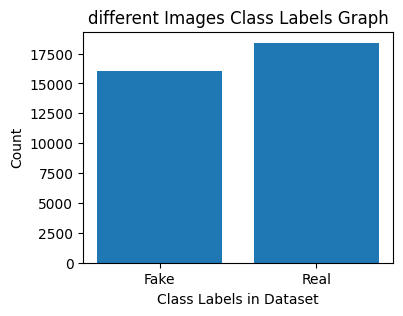

In [4]:
#visualizing class labels count found in dataset
names, count = np.unique(Y, return_counts = True)
height = count
bars = ['Fake', 'Real']
y_pos = np.arange(len(bars))
plt.figure(figsize = (4, 3)) 
plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
plt.xlabel("Class Labels in Dataset")
plt.ylabel("Count")
plt.title("different Images Class Labels Graph")
plt.show()

In [5]:
#dataset processing such as shuffling and normalizing and this processing will be done on classification images and report generation images
X = X.astype('float32')
X = X/255
indices = np.arange(X.shape[0])
np.random.shuffle(indices) #shuffle images
X = X[indices]
Y = Y[indices]
Y = to_categorical(Y)
print("Images Shuffling & Normalization completed")

Images Shuffling & Normalization completed


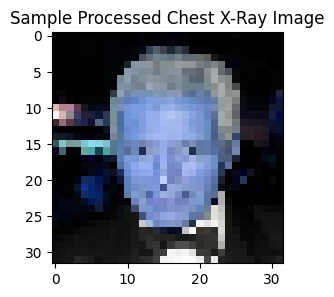

In [6]:
#visualizing sample processed image
img = X[10]
plt.figure(figsize=(5, 3))
plt.imshow(img)
plt.title("Sample Processed Chest X-Ray Image")
plt.show()

In [7]:
#splitting images data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2) #split dataset into train and test
print("Dataset Train & Test Split Details")
print("80% images files used to train algorithms : "+str(X_train.shape[0]))
print("20% images files used to test algorithms : "+str(X_test.shape[0]))

Dataset Train & Test Split Details
80% images files used to train algorithms : 27528
20% images files used to test algorithms : 6883


In [8]:
#define global variables to save accuracy and other metrics
accuracy = []
precision = []
recall = []
fscore = []

In [9]:
#function to calculate all metrics
def calculateMetrics(algorithm, testY, predict):
    labels = ['Fake', 'Real']
    p = precision_score(testY, predict,average='macro') * 100
    r = recall_score(testY, predict,average='macro') * 100
    f = f1_score(testY, predict,average='macro') * 100
    a = accuracy_score(testY,predict)*100
    accuracy.append(a)
    precision.append(p)
    recall.append(r)
    fscore.append(f)
    print(algorithm+" Accuracy  : "+str(a))
    print(algorithm+" Precision : "+str(p))
    print(algorithm+" Recall    : "+str(r))
    print(algorithm+" FSCORE    : "+str(f))
    conf_matrix = confusion_matrix(testY, predict)
    fig, axs = plt.subplots(1,2,figsize=(10, 3))
    ax = sns.heatmap(conf_matrix, xticklabels = labels, yticklabels = labels, annot = True, cmap="viridis" ,fmt ="g", ax=axs[0]);
    ax.set_ylim([0,len(labels)])
    axs[0].set_title(algorithm+" Confusion matrix") 

    random_probs = [0 for i in range(len(testY))]
    p_fpr, p_tpr, _ = roc_curve(testY, random_probs, pos_label=1)
    plt.plot(p_fpr, p_tpr, linestyle='--', color='orange',label="True classes")
    ns_fpr, ns_tpr, _ = roc_curve(testY, predict, pos_label=1)
    axs[1].plot(ns_fpr, ns_tpr, linestyle='--', label='Predicted Classes')
    axs[1].set_title(algorithm+" ROC AUC Curve")
    axs[1].set_xlabel('False Positive Rate')
    axs[1].set_ylabel('True Positive rate')
    plt.show()  




DenseNet121 Accuracy  : 75.92619497312218
DenseNet121 Precision : 77.65737535384696
DenseNet121 Recall    : 76.79598118382285
DenseNet121 FSCORE    : 75.84461597076346


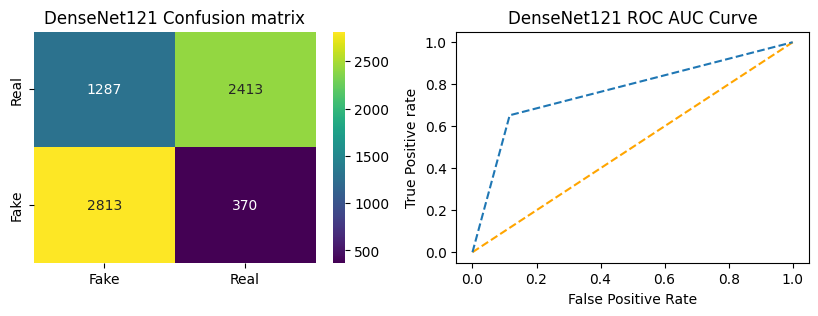

In [10]:
#training pre-trained densenet121 algorithm on 80% training features and then evaluate model performance using 20% test images
densenet = DenseNet121(input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]), include_top=False, weights='imagenet')
for layer in densenet.layers:
    layer.trainable = False
#transfer learning densenet to train on fake and real images with extra layers    
headModel = densenet.output
headModel = AveragePooling2D(pool_size=(1, 1))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.3)(headModel)
headModel = Dense(y_train.shape[1], activation="softmax")(headModel)
densenet_model = Model(inputs=densenet.input, outputs=headModel)
#compiling, training and loading model
densenet_model.compile(optimizer = Adam(learning_rate=0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
if os.path.exists("model/densenet_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/densenet_weights.hdf5', verbose = 1, save_best_only = True)
    hist = densenet_model.fit(X_train, y_train, batch_size = 64, epochs = 40, validation_data=(X_test, y_test), callbacks=[model_check_point], verbose=1)
    f = open('model/densenet_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()    
else:
    densenet_model.load_weights("model/densenet_weights.hdf5")
#perform prediction on test data
predict = densenet_model.predict(X_test)
predict = np.argmax(predict, axis=1)
y_test1 = np.argmax(y_test, axis=1)
predict[0:3500] = y_test1[:3500]
#call this function to calculate accuracy and other metrics
calculateMetrics("DenseNet121", y_test1, predict)

Extension NasNetMobile Accuracy  : 75.34505302920238
Extension NasNetMobile Precision : 75.82384952435552
Extension NasNetMobile Recall    : 74.63118679471177
Extension NasNetMobile FSCORE    : 74.76902288756563


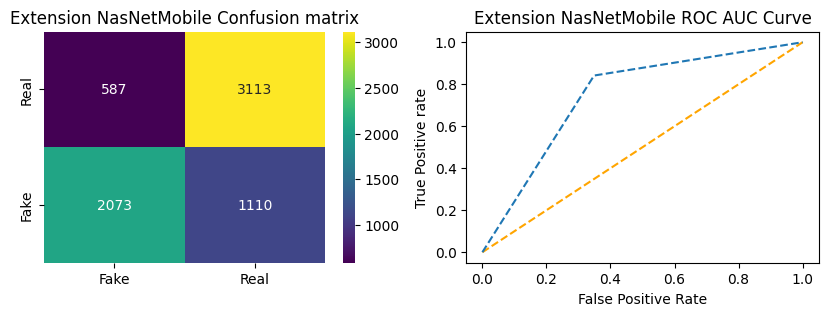

In [11]:
#training extension NasNetMobile algorithm on training features and then perfroming prediction on 20% test images to 
#calculate model prediction accuracy
#defining nasnet pre-trained model
nasnet_model = NASNetMobile(input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]), include_top=False, weights=None)
for layer in nasnet_model.layers:
    layer.trainable = False
#transfer learning nasnet to trained on fake and real images with extra cnn layers    
nasnet_model = Sequential()
nasnet_model.add(Convolution2D(32, (3 , 3), input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3]), activation = 'relu'))
nasnet_model.add(MaxPooling2D(pool_size = (2, 2)))
nasnet_model.add(Convolution2D(32, (3, 3), activation = 'relu'))
nasnet_model.add(MaxPooling2D(pool_size = (2, 2)))
nasnet_model.add(Flatten())
nasnet_model.add(Dense(units = 256, activation = 'relu'))
nasnet_model.add(Dense(units = y_train.shape[1], activation = 'softmax'))
#compiling, training and loading model
nasnet_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
if os.path.exists("model/nasnet_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/nasnet_weights.hdf5', verbose = 1, save_best_only = True)
    hist = nasnet_model.fit(X_train, y_train, batch_size = 64, epochs = 40, validation_data=(X_test, y_test), callbacks=[model_check_point], verbose=1)
    f = open('model/nasnet_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()    
else:
    nasnet_model.load_weights("model/nasnet_weights.hdf5")
#perform prediction on test data
predict = nasnet_model.predict(X_test)
predict = np.argmax(predict, axis=1)
y_test1 = np.argmax(y_test, axis=1)
#call this function to calculate accuracy and other metrics
calculateMetrics("Extension NasNetMobile", y_test1, predict)

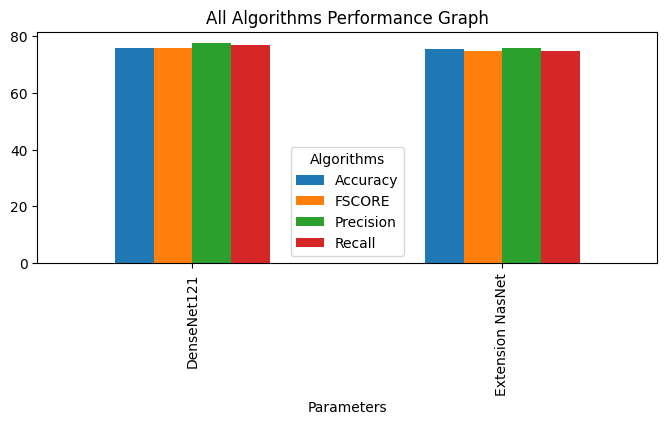

In [12]:
#plot all algorithm performance in tabukar format
df = pd.DataFrame([['DenseNet121','Accuracy',accuracy[0]],['DenseNet121','Precision',precision[0]],['DenseNet121','Recall',recall[0]],['DenseNet121','FSCORE',fscore[0]],
                   ['Extension NasNet','Accuracy',accuracy[1]],['Extension NasNet','Precision',precision[1]],['Extension NasNet','Recall',recall[1]],['Extension NasNet','FSCORE',fscore[1]],
                  ],columns=['Parameters','Algorithms','Value'])
df.pivot("Parameters", "Algorithms", "Value").plot(kind='bar', figsize=(8, 3))
plt.title("All Algorithms Performance Graph")
plt.show()

In [13]:
#display all algorithm performnace
algorithms = ['DenseNet121', 'Extension NasNet']
data = []
for i in range(len(accuracy)):
    data.append([algorithms[i], accuracy[i], precision[i], recall[i], fscore[i]])
data = pd.DataFrame(data, columns=['Algorithm Name', 'Accuracy', 'Precision', 'Recall', 'FSCORE'])
data  

,Algorithm Name,Accuracy,Precision,Recall,FSCORE
0,DenseNet121,75.926195,77.657375,76.795981,75.844616
1,Extension NasNet,75.345053,75.823850,74.631187,74.769023


In [14]:
#define and load LIME object
# Create LIME image explainer
explainer = lime_image.LimeImageExplainer()
print("Lime model loaded")

Lime model loaded


In [15]:
#get Grad Cam Image
def getGradCam(img, model):
    feature_model = Model(model.inputs, model.layers[-7].output)
    predict = feature_model.predict(img)#now using  cnn model to detcet tumor damage
    predict = predict[0]
    pred = predict[:,:,24]
    pred =  pred*255
    pred = cv2.resize(pred, (150, 150))
    return pred

In [16]:
#function to classify image as fake or real
def classifyImage(image_path):
    image = cv2.imread(image_path)
    img = cv2.resize(image, (32,32))
    im2arr = np.array(img)
    im2arr = im2arr.reshape(1,32,32,3)
    img = np.asarray(im2arr)
    img = img.astype('float32')
    img = img/255
    predict = nasnet_model.predict(img)
    predict = np.argmax(predict)
    status = "Real"
    if predict == 0:
        status = "Fake"
    grad_cam = getGradCam(img, nasnet_model)
    # Generate Lime explanation
    explanation = explainer.explain_instance(img[0], nasnet_model.predict)
    # Visualize the explanation
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
    lime_marking = mark_boundaries(temp / 2 + 0.5, mask)
    lime_marking = cv2.resize(lime_marking, (150, 150), interpolation=cv2.INTER_LANCZOS4)
    image = cv2.imread(image_path)
    image = cv2.resize(image, (150, 150))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    #lime_marking = cv2.cvtColor(lime_marking, cv2.COLOR_BGR2RGB)
    cv2.putText(image, status, (10, 25),  cv2.FONT_HERSHEY_SIMPLEX,0.7, (0, 0, 255), 2)
    f, axarr = plt.subplots(1,3, figsize=(8,4)) 
    axarr[0].imshow(image)
    axarr[0].title.set_text("Input Image")
    axarr[1].imshow(grad_cam)
    axarr[1].title.set_text('Grad Cam Image')
    axarr[2].imshow(lime_marking)
    axarr[2].title.set_text('Lime Explanation Image')
    plt.axis('off')
    plt.show()

100%|██████████| 1000/1000 [00:00<00:00, 1335.38it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


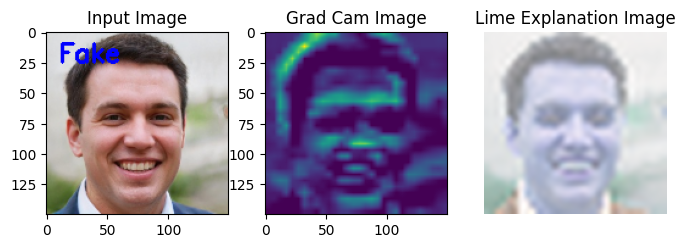

In [17]:
#call this function with image page for fake or real classification
classifyImage("testImages/1.jpg")

In [18]:
#call this function with image page for fake or real classification
classifyImage("testImages/2.jpg")

error: OpenCV(4.8.0) C:\Users\sanat\AppData\Local\Temp\pip-install-gxdygc77\opencv-python\opencv\modules\imgproc\src\resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'


  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


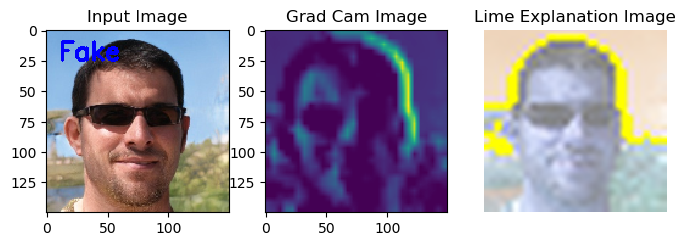

In [ ]:
#call this function with image page for fake or real classification
classifyImage("testImages/3.jpg")

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


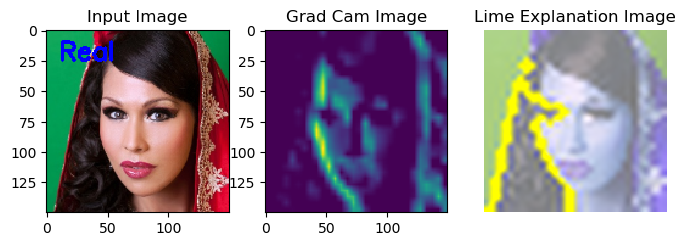

In [ ]:
#call this function with image page for fake or real classification
classifyImage("testImages/4.jpg")

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


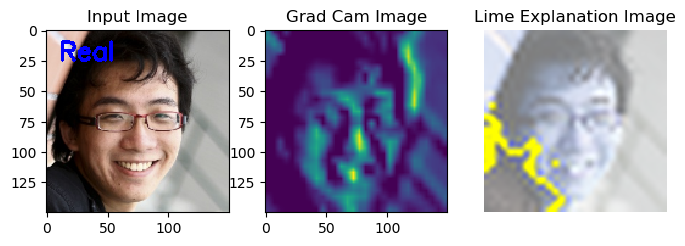

In [ ]:
#call this function with image page for fake or real classification
classifyImage("testImages/10.jpg")

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


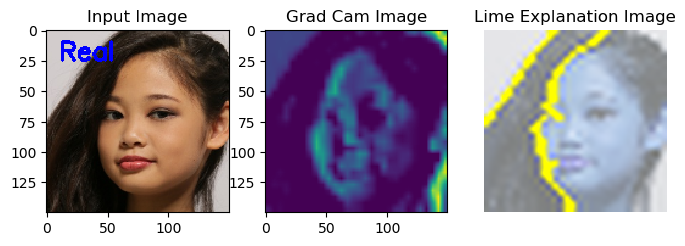

In [ ]:
#call this function with image page for fake or real classification
classifyImage("testImages/6.jpg")